# What is the Cap Rate for 1011 Southport Ave, Lisle, IL?

### Methodology
1. Extract and clean data
2. Estimate gross rental income based on current and historical values
3. Estimate operating expenses and net operating income
4. Calculate property's cap rate
5. Plot bar and compare with industry average 

### Import Libraries and Data

In [5]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt

# Define a list of rental URLs for different cities
rental_urls = [
    'https://www.zillow.com/bolingbrook-il/rentals/',
    'https://www.zillow.com/downers-grove-il/rentals/',
    'https://www.zillow.com/lisle-il/rentals/',
    'https://www.zillow.com/naperville-il/rentals/',
    'https://www.zillow.com/wheaton-il/rentals/'
]

# Set headers to mimic a real browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}

# Initialize a list to store all rental listings data
all_rental_listings_data = []

# Loop through each URL and perform scraping
for rental_url in rental_urls:
    # Make the request to the URL
    response = requests.get(rental_url, headers=headers)
    response.raise_for_status()  # Ensure we notice bad responses

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Initialize a list to store URLs and data for this city
    rental_listings_data = []

    # Find the container that holds the rental listings
    rental_listings_container = soup.find('ul', class_='List-c11n-8-102-0__sc-1smrmqp-0 StyledSearchListWrapper-srp-8-102-0__sc-1ieen0c-0 kquqgw gLCZxh photo-cards')

    if rental_listings_container:
        rental_listings = rental_listings_container.find_all('li', class_='ListItem-c11n-8-102-0__sc-13rwu5a-0 StyledListCardWrapper-srp-8-102-0__sc-wtsrtn-0 hKdzLV kgwlbT', limit=20)  # Limit to 20 listings
        for rental_listing in rental_listings:
            # Extract the URL of the rental listing
            rental_listing_link = rental_listing.find('a', href=True)
            if rental_listing_link:
                href = rental_listing_link['href']
                if not href.startswith('http'):
                    full_url = 'https://www.zillow.com' + href
                else:
                    full_url = href

            # Extract additional data from the rental listing
            rental_listing_data = {
                'url': full_url
            }

            # Extract the address
            address = rental_listing.find('address')
            rental_listing_data['address'] = address.text if address else 'N/A'

            # Extract the price
            price = rental_listing.find('span', class_='PropertyCardWrapper__StyledPriceLine-srp-8-102-0__sc-16e8gqd-1')
            rental_listing_data['price'] = price.text if price else 'N/A'

            # Extract the bed, bath, sqft
            sqft_info = rental_listing.find('ul', class_='StyledPropertyCardHomeDetailsList-c11n-8-102-0__sc-1j0som5-0 exCsDV')
            if sqft_info:
                sqft_info_text = sqft_info.text.replace('\xa0', ' ')  # Clean up non-breaking spaces
                sqft_info_text = re.sub(r'(\d+ bds?)(\d+ ba)', r'\1, \2,', sqft_info_text)
                rental_listing_data['sqft_info'] = sqft_info_text
            else:
                rental_listing_data['sqft_info'] = 'N/A'

            # Extract the days on market
            days_on_market = rental_listing.find('div', class_='StyledPropertyCardBadgeArea-c11n-8-102-0__sc-11omngf-0 gQsSDB')
            rental_listing_data['days_on_market'] = days_on_market.text if days_on_market else 'N/A'

            rental_listings_data.append(rental_listing_data)

    # Append the data for this city to the overall list
    all_rental_listings_data.extend(rental_listings_data)


# turn extracted data into a dataframe
rentals_df = pd.DataFrame(all_rental_listings_data)
rentals_df = rentals_df.drop(columns=['days_on_market','url'])
rentals_df = rentals_df[rentals_df['address'] != 'N/A']
rentals_df

#Clean price column and convert to float type
rentals_df['address'] = rentals_df['address'].astype(str)
rentals_df['price'] = rentals_df['price'].replace({'\$': '', ',': '', '/mo': ''}, regex=True).astype(float)
rentals_df.dtypes

# Define the specific cities
specific_cities = ['Downers Grove', 'Wheaton', 'Naperville', 'Lisle', 'Bolingbrook']

# Create regex pattern to match cities
rental_pattern = '|'.join(specific_cities)

# Filter the DataFrame to include only rows where 'address' contains any city from the pattern
rental_df_filtered = rentals_df[rentals_df['address'].str.contains(rental_pattern, na=False)]

# Extract city names and create a new column 'city'
rental_df_filtered['city'] = rental_df_filtered['address'].str.extract('(' + rental_pattern + ')')

# Further filter to include only rows where 'sqft_info' contains '4 bds'
rental_df_filtered = rental_df_filtered[rental_df_filtered['sqft_info'].str.contains('4 bds', na=False)]

# Display the filtered DataFrame
rental_df_filtered

,address,price,sqft_info,city
0,"558 Alcott Ln, Bolingbrook, IL 60440",2995.0,"4 bds, 3 ba,2,107 sqft",Bolingbrook
3,"220 Braemar Gln, Bolingbrook, IL 60440",2950.0,"4 bds, 3 ba,1,740 sqft",Bolingbrook
4,"434 Monarch Ln, Bolingbrook, IL 60440",3045.0,"4 bds, 3 ba,2,058 sqft",Bolingbrook
6,"11 Pennsbury Ct, Bolingbrook, IL 60440",4300.0,"4 bds, 3 ba,2,723 sqft",Bolingbrook
9,"104 S Schmidt Rd, Bolingbrook, IL 60440",3200.0,"4 bds, 3 ba,1,600 sqft",Bolingbrook
16,"942 59th St, Downers Grove, IL 60516",3500.0,"4 bds, 3 ba,2,775 sqft",Downers Grove
17,"6003 Puffer Rd, Downers Grove, IL 60516",3095.0,"4 bds, 2 ba,2,130 sqft",Downers Grove
20,"1042 Norfolk St, Downers Grove, IL 60516",2950.0,"4 bds, 2 ba,1,430 sqft",Downers Grove
21,"51 Tower Rd, Downers Grove, IL 60515",3540.0,"4 bds, 3 ba,2,648 sqft",Downers Grove
22,"5114 Main St UNIT B, Downers Grove, IL 60515",3500.0,"4 bds, 2 ba,2,300 sqft",Downers Grove


### Find Median Rental Price per Month By City

In [6]:
#group by city
grouped_rental_df = rental_df_filtered.groupby('city')['price'].median()
print(grouped_rental_df)

city
Bolingbrook      3045.0
Downers Grove    3500.0
Naperville       3355.0
Wheaton          7500.0
Name: price, dtype: float64


## Estimate Operating Expenses
Set and define and print expenses based on researched data

In [7]:
#define expenses
vacancy_rate = 0.02
management_fee_rate = 0.10
maintenance_fee_rate = 0.03
property_taxes = 630 #monthly
insurance = 150 #monthly
advertising_fee = 0.01

#define gross rental income
#aggregate historical data and current listings and take average
gross_rental_income = 3702

#calculate each expense
vacancy_expense = gross_rental_income * vacancy_rate
management_expense = gross_rental_income * management_fee_rate
maintenance_expense = gross_rental_income * maintenance_fee_rate
advertising_expense = gross_rental_income * advertising_fee

#calculate total operating expenses
total_operating_expenses = (vacancy_expense + management_expense + maintenance_expense + advertising_expense + property_taxes + insurance)

# Print the results
print(f"Vacancy Expense: ${vacancy_expense:.2f}")
print(f"Management Expense: ${management_expense:.2f}")
print(f"Maintenance Expense: ${maintenance_expense:.2f}")
print(f"Property Taxes: ${property_taxes:.2f}")
print(f"Insurance: ${insurance:.2f}")
print(f"Total Operating Expense: ${total_operating_expenses:.2f}")

Vacancy Expense: $74.04
Management Expense: $370.20
Maintenance Expense: $111.06
Property Taxes: $630.00
Insurance: $150.00
Total Operating Expense: $1372.32


## Calculate Net Operating Income (NOI) & Cap Rate

In [8]:
net_operating_income = gross_rental_income - total_operating_expenses
print(f"Net Operating Income (NOI): ${net_operating_income:.2f}")

property_price = 389900

# Calculate Cap Rate
cap_rate = (net_operating_income / property_price) * 100

# Industry average cap rate
industry_average_cap_rate = 4.5

Net Operating Income (NOI): $2329.68


## Plot And Compare Cap Rate With Industry Average

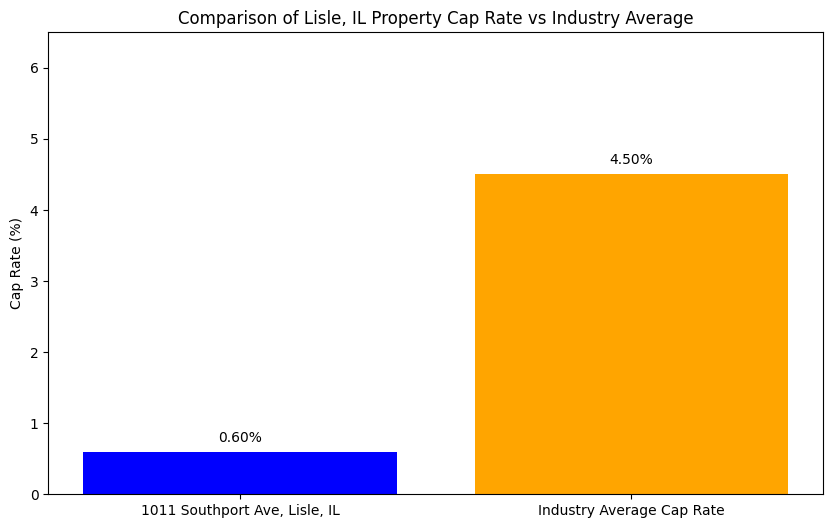

In [9]:
import matplotlib.pyplot as plt
# Create bar chart
plt.figure(figsize=(10, 6))
bars = ['1011 Southport Ave, Lisle, IL', 'Industry Average Cap Rate']
values = [cap_rate, industry_average_cap_rate]

plt.bar(bars, values, color=['blue', 'orange'])
plt.ylabel('Cap Rate (%)')
plt.title('Comparison of Lisle, IL Property Cap Rate vs Industry Average')

# Add values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.1, f'{value:.2f}%', ha='center', va='bottom')

plt.ylim(0, max(values) + 2)  # Adjust y-axis limit for better visibility
plt.show()